# Linear Image Registration with AIRLAB

This notebook is adapted from https://github.com/airlab-unibas/airlab/blob/master/examples/affine_registration_3d.py

In [1]:
import airlab as al
import numpy as np
import torch

import utility as util

## Load images

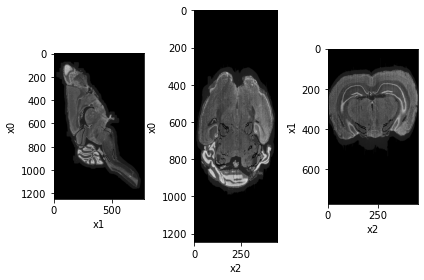

In [2]:
fixed_image = np.load('../data/local/MD589_CH1.npy')
fixed_image = util.normalize_intensity(fixed_image)
util.imshow_midslice(fixed_image)

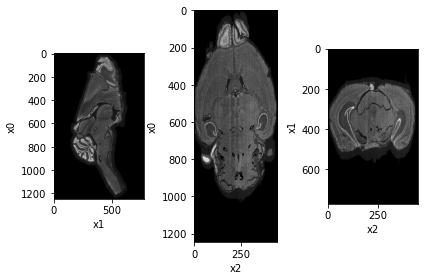

In [3]:
moving_image = np.load('../data/local/MD594_CH1.npy')
moving_image = util.normalize_intensity(moving_image)
util.imshow_midslice(moving_image)

## Prepare images for registration

In [4]:
dtype = torch.float32
device = torch.device('cpu')
fixed_image = torch.tensor(fixed_image, dtype=dtype).to(device)
fixed_image = al.Image(fixed_image, fixed_image.shape, [1, 1, 1], [0, 0, 0])
moving_iamge = torch.tensor(moving_image, dtype=dtype).to(device)
moving_image = al.Image(moving_image, moving_image.shape, [1, 1, 1], [0, 0, 0])

## Configure registration

In [5]:
lr = 1e-2
scales = [[8, 8, 8], [4, 4, 4], [2, 2, 2]]
niter = [128, 32, 16, 4]

fixed_image_pyramid = al.create_image_pyramid(fixed_image, scales)
moving_image_pyramid = al.create_image_pyramid(moving_image, scales)

## Run registration

In [6]:
import time

start = time.time()

for level, (mov_im, fix_im) in enumerate(zip(moving_image_pyramid, fixed_image_pyramid)):
    print('level', level)
    registration = al.PairwiseRegistration(verbose=True)
    
    transformation = al.transformation.pairwise.AffineTransformation(mov_im)
    if level == 0:
        transformation.init_translation(fix_im)
    else:
        transformation.set_parameters(**parameters)
    registration.set_transformation(transformation)
    
    image_loss = al.loss.pairwise.MSE(fix_im, mov_im)
    registration.set_image_loss([image_loss])
    
    optimizer = torch.optim.Adam(transformation.parameters(), lr=lr)
    registration.set_optimizer(optimizer)
    
    registration.set_number_of_iterations(niter[level])
    registration.start()
    
    parameters = {
        't': (
            float(transformation._t_x),
            float(transformation._t_y),
            float(transformation._t_z)
        ),
        'phi': (
            float(transformation._phi_z),
            float(transformation._phi_x),
            float(transformation._phi_y),
        ),
        'scale': (
            float(transformation._scale_x),
            float(transformation._scale_y),
            float(transformation._scale_z)
        ),
        'shear': (
            float(transformation._shear_y_x),
            float(transformation._shear_x_y),
            float(transformation._shear_z_x),
            float(transformation._shear_z_y),
            float(transformation._shear_x_z),
            float(transformation._shear_y_z),
        ),
    }

end = time.time()
print((end - start) / 60, 'min')

level 0
0 mse: 0.012420239091843189 


/home/b2dong/registration-study/env/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


1 mse: 0.012078161666925368 

/home/b2dong/registration-study/env/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(



2 mse: 0.01169239448756716 
3 mse: 0.011390960865731685 
4 mse: 0.011103491512258904 
5 mse: 0.010859803099512002 
6 mse: 0.01057921291105211 
7 mse: 0.010365839659251688 
8 mse: 0.010109264739956195 
9 mse: 0.009855447568387292 
10 mse: 0.009650280059533181 
11 mse: 0.009454984440199833 
12 mse: 0.009262402659314058 
13 mse: 0.00905540149039591 
14 mse: 0.008816670229136 
15 mse: 0.008558068902587859 
16 mse: 0.008302906272146986 
17 mse: 0.008042506277263332 
18 mse: 0.0078055226700760256 
19 mse: 0.007573830193344115 
20 mse: 0.007332112641756387 
21 mse: 0.007074059911651791 
22 mse: 0.006805049225466833 
23 mse: 0.006524497359384341 
24 mse: 0.006223441604742533 
25 mse: 0.005929682883253634 
26 mse: 0.005636993937223298 
27 mse: 0.0053422629019404255 
28 mse: 0.005032045453067264 
29 mse: 0.00471853032961691 
30 mse: 0.004398082889113522 
31 mse: 0.00407942643484872 
32 mse: 0.0037720129542880764 
33 mse: 0.0034641379201110554 
34 mse: 0.00316351886338865 
35 mse: 0.002907232112

## Examine results

In [7]:
transformation.print()

_phi_z 0.06661924036694918
_t_x 0.005899872532133878
_t_y 0.09479759986455363
_t_z -0.0187512471459746
_phi_x 0.3958513600221813
_phi_y 0.044069065142444894
_scale_x 0.9652621901511307
_scale_y 0.9703147457899879
_scale_z 1.1724594263744654
_shear_y_x 0.031009976470381822
_shear_x_y -0.019585081107527325
_shear_z_x 0.026052960750267515
_shear_z_y -0.35142957404161973
_shear_x_z 0.009919452726128689
_shear_y_z -0.10970272410798085


In [8]:
displacement = transformation.get_displacement()
warped_image = al.transformation.utils.warp_image(moving_image, displacement)

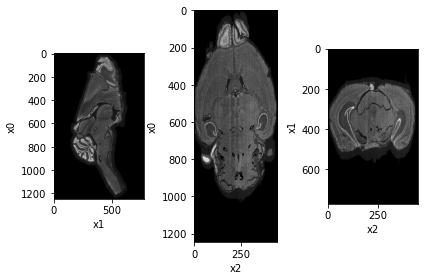

In [9]:
util.imshow_midslice(moving_image.image[0,0].numpy())

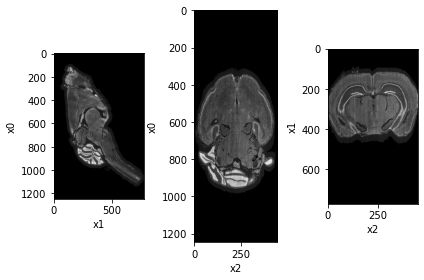

In [ ]:
util.imshow_midslice(warped_image.image[0,0].numpy())

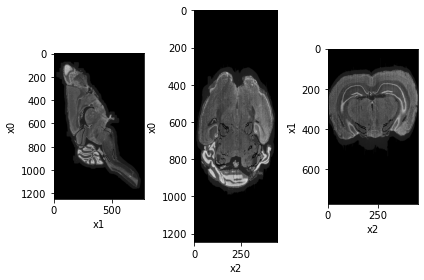

In [ ]:
util.imshow_midslice(fixed_image.image[0,0].numpy())